# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 04.12.2019

Мягкий дедлайн: 05:59MSK 15.12.2019

Жесткий дедлайн: 05:59MSK 17.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15.5 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style('darkgrid')

In [121]:
from sklearn.model_selection import train_test_split

## __Задание 1. (0.5 балла)__

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [199]:
data = pd.read_csv('./hse19-gbm/application_train.csv', index_col=['SK_ID_CURR'])

In [222]:
data.dtypes

TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64


In [224]:
data.loc[:, data.dtypes==np.int64].nunique()

TARGET                             2
CNT_CHILDREN                      14
DAYS_BIRTH                     17396
DAYS_EMPLOYED                  11792
DAYS_ID_PUBLISH                 6111
FLAG_MOBIL                         2
FLAG_EMP_PHONE                     2
FLAG_WORK_PHONE                    2
FLAG_CONT_MOBILE                   2
FLAG_PHONE                         2
FLAG_EMAIL                         2
REGION_RATING_CLIENT               3
REGION_RATING_CLIENT_W_CITY        3
HOUR_APPR_PROCESS_START           24
REG_REGION_NOT_LIVE_REGION         2
REG_REGION_NOT_WORK_REGION         2
LIVE_REGION_NOT_WORK_REGION        2
REG_CITY_NOT_LIVE_CITY             2
REG_CITY_NOT_WORK_CITY             2
LIVE_CITY_NOT_WORK_CITY            2
FLAG_DOCUMENT_2                    2
FLAG_DOCUMENT_3                    2
FLAG_DOCUMENT_4                    2
FLAG_DOCUMENT_5                    2
FLAG_DOCUMENT_6                    2
FLAG_DOCUMENT_7                    2
FLAG_DOCUMENT_8                    2
F

In [201]:
data.loc[:, data.dtypes==np.int64] = data.loc[:, data.dtypes==np.int64].fillna(0)
data.loc[:, data.dtypes==np.float64] = data.loc[:, data.dtypes==np.float64].fillna(0)
data.loc[:, data.dtypes==np.object] = data.loc[:, data.dtypes==np.object].fillna("")

In [231]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

In [203]:
cat_cols_obj = list(X.loc[:, X.dtypes==np.object].columns)

In [225]:
cat_cols_num = list(X.loc[:, X.dtypes==np.int64].columns[X.loc[:, X.dtypes==np.int64].nunique() <= 3])

In [226]:
cat_cols_num_for_ohe = list(X.loc[:, X.dtypes==np.int64].columns[X.loc[:, X.dtypes==np.int64].nunique()== 3])

In [227]:
cat_ohe = cat_cols_num_for_ohe + cat_cols_obj

In [205]:
cat = cat_cols_num + cat_cols_obj

In [206]:
num = set(X.columns) - set(cat)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [208]:
X_train.shape

(150679, 120)

## __Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [345]:
from sklearn.metrics import auc, precision_recall_curve

def auc_pr(y_test, y_prob):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    return auc(recall, precision)

In [135]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
from time import time

In [140]:
lgbm = LGBMClassifier()
curr = time()
lgbm.fit(X_train[num], y_train)
trained = time() - curr
y_lgbm = lgbm.predict_proba(X_test[num])[:, 1]
print('LGBM score:', auc_pr(y_test, y_lgbm))
print("Time trained", trained)

LGBM classifier score: 0.23228945578279137
Time trained 1.7021019458770752


In [143]:
cb = CatBoostClassifier(silent=True)
curr = time()
cb.fit(X_train[num], y_train)
trained = time() - curr
y_cb = cb.predict_proba(X_test[num])[:, 1]
print('Catboost classifier score:', auc_pr(y_test, y_cb))
print("Time trained", trained)

Catboost classifier score: 0.23751297416377048
Time trained 30.60211992263794


Качество получилось немного лучше у `catboost`.Он менее чувствительный к подбору гиперпараметров, чем `lightgbm`. Но по времени, разница больше, чем в два раза! Будем молиться, что при подборе гиперпараметров разница во времени будет не такой большой).

## __Задание 3. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал. `можно игнорировать`

Масштаб значений предлагается посмотреть в семинаре про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

### LGBM GS

In [316]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [317]:
params = {'n_estimators': [100, 400, 800, 500],
         'max_depth': list(range(2, 10, 2)), 
         'learning_rate':[0.1, 0.05, 0.15]}

In [318]:
scorer = make_scorer(auc_pr, needs_proba=True)

In [319]:
gs = GridSearchCV(LGBMClassifier(), param_grid=params, cv=3, scoring=scorer)

curr = time()
gs.fit(X_train[num], y_train)
trained = time()- curr
print("GS time", trained)
print(gs.best_params_)

GS time 530.543535232544
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 800}


In [380]:
lgbm_best = LGBMClassifier().set_params(**gs.best_params_)

In [381]:
curr = time()
lgbm_best.fit(X_train[num], y_train)
time()-curr

4.96002197265625

In [382]:
print("AUC PR: %6f" % auc_pr(y_test, lgbm_best.predict_proba(X_test[num])[:, 1]))

AUC PR: 0.240642


### Catboost GS

In [170]:
params = {'n_estimators': [100, 400, 800, 1000],
         'max_depth': list(range(2, 10, 2)), 
         'learning_rate':[0.1, 0.05, 0.15]}

In [171]:
gs_cb = GridSearchCV(CatBoostClassifier(silent=True), param_grid=params, cv=3, scoring=scorer)

curr = time()
gs_cb.fit(X_train[num], y_train)
trained = time()- curr
print("GS time", trained)
print(gs_cb.best_params_)

GS time 1952.1113641262054
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1000}


In [173]:
cb_best = CatBoostClassifier(silent=True).set_params(**gs_cb.best_params_)

In [402]:
curr = time()
cb_best.fit(X_train[num], y_train)
time()- curr

27.12384796142578

In [403]:
print("AUC PR: %6f" % auc_pr(y_test, cb_best.predict_proba(X_test[num])[:, 1]))

AUC PR: 0.239741


CatBoost строит деревья глубже (хотя мог и еще глубже, но не стал, но не сильно больше `LGBM`) и сильно больше деревьев, но и качество лучше значительно ))

## __Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

### OHE+LGBM

In [274]:
X_ohe = pd.get_dummies(X, columns=cat_ohe)

In [275]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y, test_size=0.3, random_state = 42) # иначе просто не разбитвается :(

In [277]:
X_train_ohe.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train_ohe.columns]

In [278]:
X_test_ohe.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_ohe.columns]

In [286]:
lgbm_ohe = LGBMClassifier()

curr = time()
lgbm_ohe.fit(X_train_ohe, y_train_ohe)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_lgbm_ohe = lgbm_ohe.predict_proba(X_test_ohe)
print('AUC PR: %.6f' % auc_pr(y_test_ohe, y_pred_lgbm_ohe[:, 1]))

Train time: 3.328472s
AUC PR: 0.235980


### OHE + CatBoost

In [287]:
cb_ohe = CatBoostClassifier(silent=True)

curr = time()
cb_ohe.fit(X_train_ohe, y_train_ohe)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_cb_ohe = cb_ohe.predict_proba(X_test_ohe)
print('AUC PR: %.6f' % auc_pr(y_test_ohe, y_pred_cb_ohe[:, 1]))

Train time: 30.474608s
AUC PR: 0.244545


### Счетчики + LGBM

In [298]:
from tqdm import tqdm

In [303]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X, y, test_size=0.3, random_state=42)

In [304]:
def counter(col,  C):
    train = pd.Series(X_train_count[col], name='train')
    target = pd.Series(y_train_count, name='target')
    curr = pd.concat((train, target), axis=1)
    
    glb_mean = curr['target'].mean()
    agg = curr.groupby('train')['target'].agg(['count', 'mean'])
    cntr = (agg['count'] * agg['mean'] + C * glb_mean) / (agg['count'] + C)
    
    X_train_count.loc[:, col] = curr['train'].map(cntr).values
    X_test_count.loc[:, col] = X_test_count[col].map(cntr).values
    
# частично взято отсюда https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

In [307]:
c = 0.5

for col in tqdm(cat):
    counter(col, c)

100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


In [308]:
lgbm_cnt = LGBMClassifier()

curr = time()
lgbm_cnt.fit(X_train_count, y_train_count)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_lgbm_cnt = lgbm_cnt.predict_proba(X_test_count)
print('AUC PR: %.6f' % auc_pr(y_test_count, y_pred_lgbm_cnt[:, 1]))

Train time: 2.782073s
AUC PR: 0.239147


### Счетчики + Catboost

In [309]:
cb_cnt = CatBoostClassifier(silent=True)

curr = time()
cb_cnt.fit(X_train_count, y_train_count)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_cb_cnt = cb_cnt.predict_proba(X_test_count)
print('AUC PR: %.6f' % auc_pr(y_test_count, y_pred_cb_cnt[:, 1]))

Train time: 33.406987s
AUC PR: 0.245289


### Внутренние методы LGBM

*Ремарка: `LGBM` использует `sklearn API`, то есть автоматически определяет категориальные переменные, если в `Pandas DataFrame` колонка имеет тип `category`*

In [310]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X, y, test_size=0.3, random_state=42)

In [328]:
lgbm_inner = LGBMClassifier()

for col in tqdm(cat):
    X_train_inner[col] = X_train_inner[col].astype('category')
    X_test_inner[col] = X_test_inner[col].astype('category')

100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


In [330]:
curr = time()
lgbm_inner.fit(X_train_inner, y_train_inner)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_lgbm_inner = lgbm_inner.predict_proba(X_test_inner)
print('AUC PR: %.6f' % auc_pr(y_test_inner, y_pred_lgbm_inner[:, 1]))

Train time: 3.272484s
AUC PR: 0.238503


### Внутренние методы CatBoost

In [326]:
cb_inner = CatBoostClassifier(silent=True, cat_features=cat)

In [327]:
curr = time()
cb_inner.fit(X_train_inner, y_train_inner)
trained = time() - curr
print('Train time: %.6fs' % trained)

y_pred_cb_inner = cb_inner.predict_proba(X_test_inner)
print('AUC PR: %.6f' % auc_pr(y_test_inner, y_pred_cb_inner[:, 1]))

Train time: 146.498355s
AUC PR: 0.246145


OHE значительно повлиял на время обучения для LGBM (приблизительно, увеличил в два раза относительно самой первой модели), хотя для CatBoost ничего плюс минус не поменялось. Со счетчиками время не так сильно, но увеличивается (даже для CatBoost). Встроенные методы LGBM по времени такие же как OHE. Но CatBoost просто лидер в вопросе внутренних методов, потому что он так обучается больше двух минут, что вообще неожиданно для предустановленных методов, чувсвтвуется, что меня где-то обманули.


По качеству: 
* LGBM: OHE $<$ встроенные методы $<$ сглаженные счетчики
* CatBoost: сглаженные счетчики $<$ OHE $<$ встроенные методы
    
*Хотя, LightGBM $<$ CatBoost практически всегда(если нам плевать на время обучения), и это было ожидаемо*

## __Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

### Ленивый вариант

In [331]:
y_pred_lazy_blended = (y_pred_lgbm_ohe + y_pred_lgbm_inner + 
                       y_pred_lgbm_cnt + y_pred_cb_ohe + y_pred_cb_inner + y_pred_cb_cnt)/6

In [333]:
print('AUC PR: %.6f' % auc_pr(y_test_count, y_pred_lazy_blended[:, 1]))

AUC PR: 0.248558


### Вариант для умных и терпеливых

In [343]:
def select_weights(y_true, y_pred_1, y_pred_2): # код из семинара
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([auc_pr(y_true, y_a[:, 1]), w_0, w_1])
    return metric

Сделаю блендинг всех пар

In [354]:
prs = []
models = {'y_pred_lgbm_ohe' : y_pred_lgbm_ohe, 'y_pred_lgbm_inner' : y_pred_lgbm_inner, 
                       'y_pred_lgbm_cnt' : y_pred_lgbm_cnt, 'y_pred_cb_ohe' :y_pred_cb_ohe,
          'y_pred_cb_inner' : y_pred_cb_inner, 'y_pred_cb_cnt': y_pred_cb_cnt}
for m_1 in tqdm(models):
    for m_2 in tqdm(models):
        if m_1 != m_2:
            pr, w_0, w_1 = min(select_weights(y_test_count, models[m_1], models[m_2]), key=lambda x: x[0])
            prs.append(pr)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:07<00:15,  3.92s/it]

 50%|█████     | 3/6 [00:15<00:15,  5.10s/it]

 67%|██████▋   | 4/6 [00:23<00:11,  5.94s/it]

 83%|████████▎ | 5/6 [00:31<00:06,  6.55s/it]

 17%|█▋        | 1/6 [00:39<03:17, 39.55s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:07<00:39,  7.91s/it]

 50%|█████     | 3/6 [00:15<00:20,  6.73s/it]

 67%|██████▋   | 4/6 [00:23<00:14,  7.13s/it]

 83%|████████▎ | 5/6 [00:31<00:07,  7.39s/it]

 33%|███▎      | 2/6 [01:19<02:38, 39.64s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:07<00:39,  7.90s/it]

 33%|███▎      | 2/6 [00:15<00:31,  7.89s/it]

 67%|██████▋   | 4/6 [00:23<00:13,  6.70s/it]

 83%|████████▎ | 5/6 [00:31<00:07,  7.06s/it]

 50%|█████     | 3/6 [01:58<01:58, 39.55s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:08<00:41,  8.20s/it]

 33%|███▎      | 2/6 [00:16<00:32,  8.12s/it]

 50%|

In [356]:
set(prs)

{0.23597952410440975,
 0.2385026585508898,
 0.23914705150510382,
 0.244544993161129,
 0.24528939716159398}

Результаты не очень :( Лучше ленивый вариант

## __Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

### LGBM

In [414]:
df = pd.DataFrame(columns=['feature', 'importance'])
for val, name in sorted(zip(lgbm_best.feature_importances_, X_train[num].columns.values), reverse=True):
    df = df.append({'feature' : name, 'importance' : val}, ignore_index=True)

Text(0.5, 1.0, 'Feature importances for LGBM')

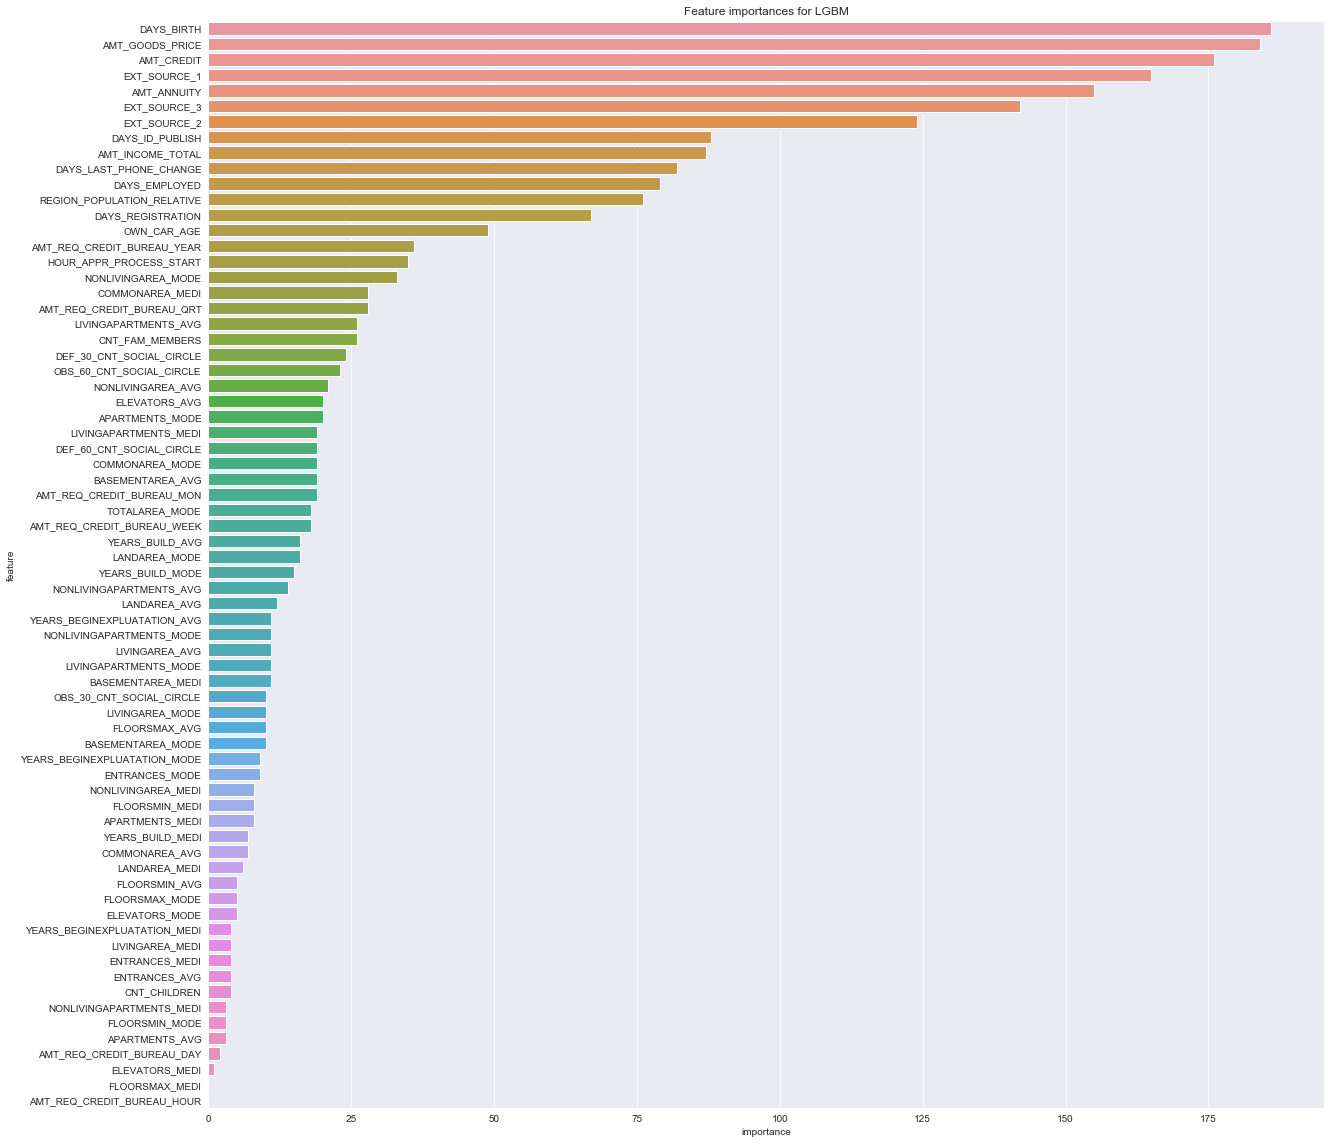

In [415]:
plt.figure(figsize=(20, 20))
sns.barplot(x='importance', y='feature', data=df)
plt.title('Feature importances for LGBM')

In [416]:
new_f = list(df[df['importance'] > 25]['feature'])

In [417]:
len(new_f), len(X_train[num].columns)

(21, 70)

In [418]:
X_train_new = X_train[new_f]
X_test_new = X_test[new_f]

In [419]:
lgbm_best.fit(X_train_new, y_train)

y_pred = lgbm_best.predict_proba(X_test_new)
print('AUC PR: %.6f' % auc_pr(y_test, y_pred[:, 1]))

AUC PR: 0.239731


### CatBoost

In [404]:
df = pd.DataFrame(columns=['feature', 'importance'])
for val, name in sorted(zip(cb_best.feature_importances_, X_train[num].columns.values), reverse=True):
    df = df.append({'feature' : name, 'importance' : val}, ignore_index=True)

Text(0.5, 1.0, 'Feature importances for CatBoost')

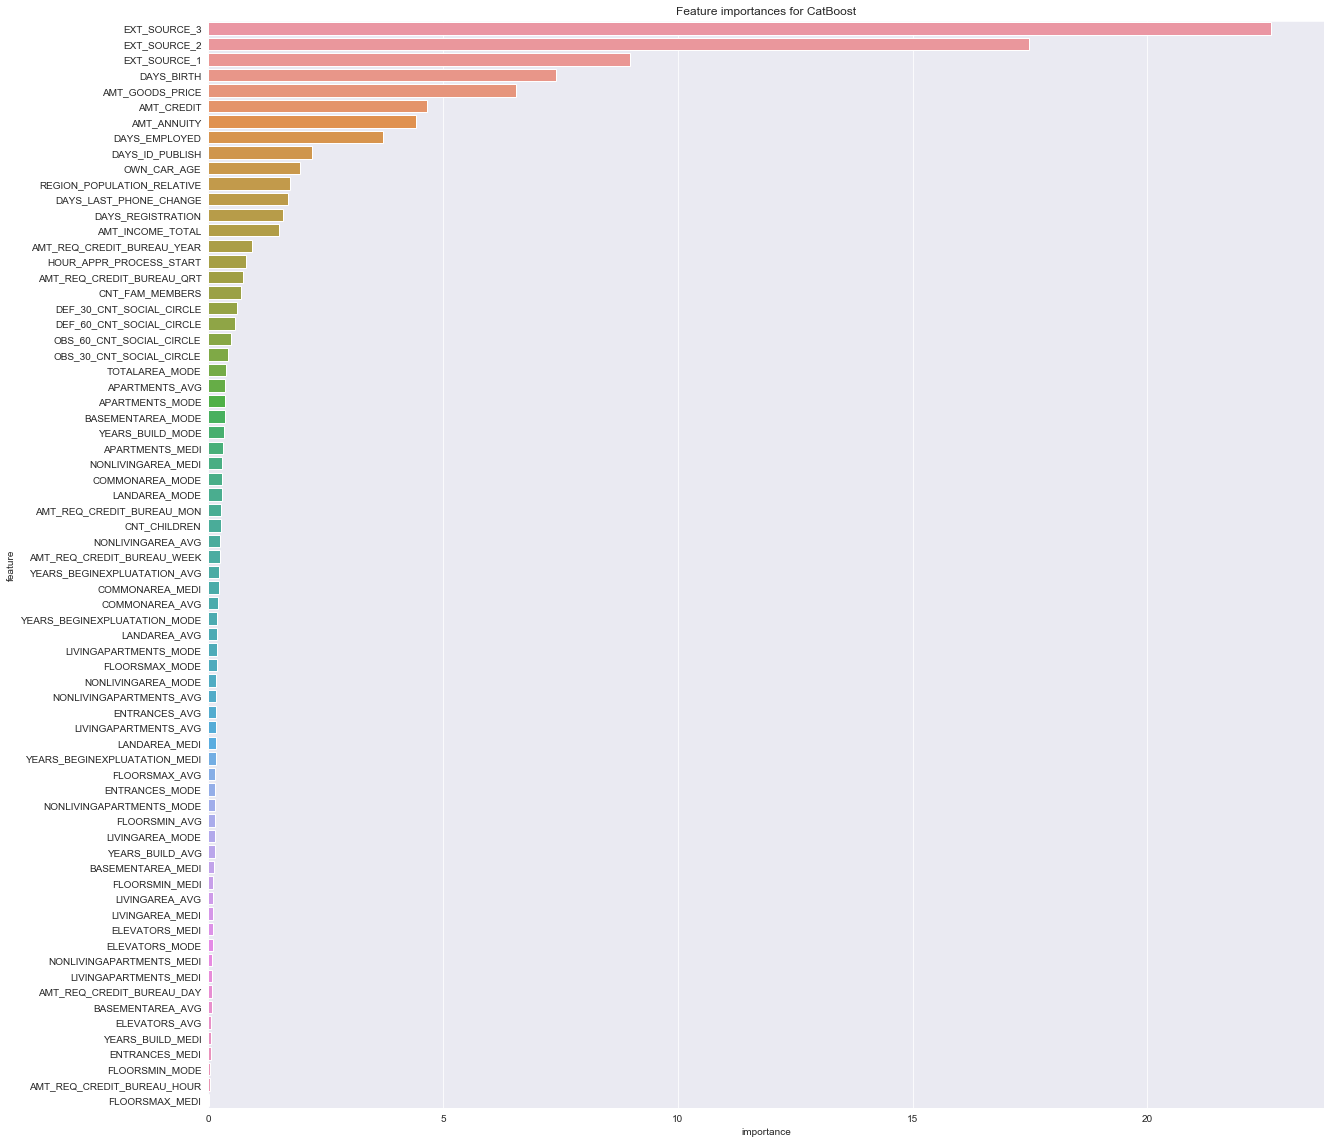

In [405]:
plt.figure(figsize=(20, 20))
sns.barplot(x='importance', y='feature', data=df)
plt.title('Feature importances for CatBoost')

In [406]:
new_f = list(df[df['importance'] > 1.2]['feature'])

In [407]:
len(new_f), len(X_train[num].columns)

(14, 70)

In [408]:
X_train_new = X_train[new_f]
X_test_new = X_test[new_f]

In [409]:
cb_best.fit(X_train_new, y_train)

y_pred = cb_best.predict_proba(X_test_new)
print('AUC PR: %.6f' % auc_pr(y_test, y_pred[:, 1]))

AUC PR: 0.239536


Разница не критичная (порядка $10^{-4}$) для обоих моделей, но при этом мы сильно уменьшаем количество признаков, соответсвенно и время обучения тоже

# Бонус

__Задание 7. (Максимум 5 баллов)__

Градиентный бустинг при всех ограничениях зачастую является ультимативным решением для задач с табличными данными; соревнование от Home Credit не стало исключением. Предлагается любыми модификациями Catboost и LightGBM (другими моделями пользоваться нельзя), обработки данных и построения признаков получить высокое качество на __приватном__ наборе данных. 
Баллы можно получить за следующие значения метрики в inclass-соревновании на Kaggle:
* 0.7955 - 1 балл
* 0.7975 - 3 баллов
* 0.80 - 5 баллов.

При сдаче этого задания необходимо приложить код, с помощью которого можно получить ту же самую метрику, что и в вашем посылке в соревновании. Если решение не будет воспроизводимым, задание засчитано не будет.

Учетная запись на kaggle: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 8. (0.5 балла)__ Обратите внимание, что в соревновании метрикой выступает AUC-ROC, у нас же до этого оптимизировался AUC-PR. Можно ли утверждать, что нет необходимости в переобучении моделей для максимизации новой метрики, если мы нашли лучший алгоритм с точки зрения AUC-PR?

http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf

если оптимизируем аук рок, то есть шансы, что мы не попадем в максимальный аук пр. Обратно, ситуация та же :(